In [1]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
def f(x, y):
    "Objective function"
    return (x-3.14)**2 + (y-2.72)**2 + np.sin(3*x+1.41) + np.sin(4*y-1.73)

In [98]:
def levy_step(mu=1.5):
    """Generate a step length from a Levy distribution."""
    return np.random.pareto(mu)  # Using Pareto distribution for Levy flight

In [159]:
class Particle:
    def __init__(self, env, name, particles, X=np.array([0.1, 0.1]), target = np.array([2.5,2.5]), c1=0.1, c2=0.1, w=0.8, speed=0.015433, transRange=1.0):
        self.env = env
        self.name = name
        self.particles = particles  # List of all particles
        self.c1 = c1
        self.c2 = c2
        self.w = w
        self.transmission_range = transRange
        self.speed = speed # 0.015433 -> 3 knots
        self.stop_flag = False # when find the target stop

        self.X = X
        self.target = target
        self.V = np.random.randn(2) * 0.1
        self.pbest_position = self.X.copy()
        self.pbest_fitness = f(self.X[0], self.X[1])

        self.nbest_position = self.X.copy()
        self.nbest_fitness = self.pbest_fitness

        self.positions = [self.X.copy()]

        self.process = env.process(self.run())

    def broadcast(self):
        """Broadcast nbest to other particles based on proximity."""
        for particle in self.particles:
            if particle != self:
                distance = np.linalg.norm(self.X - particle.X) # Euclidean distance
                if distance < self.transmission_range:  # Accoustic module Transmission range
                    particle.receive(self.nbest_position, self.nbest_fitness)

    def receive(self, nbest_position, nbest_fitness):
        """update the personal nbest"""
        if nbest_fitness < self.nbest_fitness:
            self.nbest_position = nbest_position.copy()
            self.nbest_fitness = nbest_fitness
    
    def update(self):
        r1, r2 = np.random.rand(2)
        self.V = self.w * self.V + self.c1 * r1 * (self.pbest_position - self.X) + self.c2 * r2 * (self.nbest_position - self.X)
        self.target = self.X + self.V

    def sensing(self):
        fitness = f(self.X[0], self.X[1])

        if fitness < self.pbest_fitness:
            self.pbest_position = self.X.copy()
            self.pbest_fitness = fitness

        if fitness < self.nbest_fitness:
            self.nbest_position = self.X.copy()
            self.nbest_fitness = fitness

    def move(self):
        direction = self.target-self.X
        self.X = self.X + self.speed * (direction / np.linalg.norm(direction))
        distance = np.linalg.norm(self.X - self.target) # Euclidean distance
        if distance <= 0.03:  # Interaction threshold
            self.update()
            print(self.name," Updated! ", self.V, " nbest_loc ", self.nbest_position, " nbest_fit ", self.nbest_fitness)

    def run(self):
        i = 0
        while True:
            self.sensing()
            self.move()
            if i%5 ==0:
                self.broadcast()  # broadcast nbest to neighbors
            if i%10 ==0:    
                self.positions.append(self.X.copy()) # take the records of position
            i = i + 1
            yield self.env.timeout(1)

In [151]:
def initialize_grid_particles(n_particles, start, end):
    """Evenly distribute particles on a grid within the search space."""
    list_particles = []
    
    # Determine the number of rows and columns based on the number of particles
    n_side = int(np.ceil(np.sqrt(n_particles)))  # Number of rows and columns in the grid
    x_coords = np.linspace(start, end, n_side)
    y_coords = np.linspace(start, end, n_side)

    # Create particles and assign grid positions
    for i in range(n_particles):
        # Calculate grid coordinates (i.e., row and column)
        row = i // n_side
        col = i % n_side
        grid_position = np.array([x_coords[col], y_coords[row]])  # Assign grid position
        list_particles.append(grid_position)
    
    return list_particles

In [152]:
def initialize_arc_particles(n_particles, radius):
    """Evenly distribute particles on an arc from 0 to pi/2."""
    particles_postions = []
    
    start_angle = (np.pi / 2)*(5/90)
    end_angle = (np.pi / 2)*(85/90)

    # Generate evenly spaced angles between 0 and pi/2
    angles = np.linspace(start_angle, end_angle, n_particles)

    # Create particles and assign positions based on the arc
    for i, theta in enumerate(angles):
        # Convert polar coordinates to Cartesian (x, y)
        x = radius * np.cos(theta)
        y = radius * np.sin(theta)
        position = np.array([x, y])  # Particle position on the arc
        particles_postions.append(position)
    
    return particles_postions

In [156]:
def simulate_pso():
    env = simpy.Environment()
    n_particles = 20
    # start = 0.25
    # end = 5.0-0.25
    radius = 5
    list_particles = initialize_arc_particles(n_particles, radius)

    particles = [Particle(env, f'Particle {i}', [], target=list_particles[i]) for i in range(n_particles)]
    for particle in particles:
        particle.particles = particles  # Give each particle the list of all particles
    
    env.run(until=1500)

    global_best = min(particles, key=lambda p: p.pbest_fitness)
    return [p.positions for p in particles], global_best.pbest_position, global_best.pbest_fitness

In [157]:
positions, nbest, nbest_obj = simulate_pso()

Particle 8  Updated!  [-0.17039232 -0.10214601]  nbest_loc  [3.29154209 3.05886561]  nbest_fit  -1.7029998447007206
Particle 9  Updated!  [-0.04556683 -0.07209669]  nbest_loc  [3.29154209 3.05886561]  nbest_fit  -1.7029998447007206
Particle 10  Updated!  [-0.06469604 -0.18626999]  nbest_loc  [3.29154209 3.05886561]  nbest_fit  -1.7029998447007206
Particle 11  Updated!  [-0.11101603  0.0485572 ]  nbest_loc  [3.29154209 3.05886561]  nbest_fit  -1.7029998447007206
Particle 3  Updated!  [-0.26404836  0.13872077]  nbest_loc  [3.29154209 3.05886561]  nbest_fit  -1.7029998447007206
Particle 4  Updated!  [-0.18587499  0.05341006]  nbest_loc  [3.29154209 3.05886561]  nbest_fit  -1.7029998447007206
Particle 5  Updated!  [-0.28593153 -0.00862323]  nbest_loc  [3.29154209 3.05886561]  nbest_fit  -1.7029998447007206
Particle 6  Updated!  [-0.17928467  0.06088329]  nbest_loc  [3.29154209 3.05886561]  nbest_fit  -1.7029998447007206
Particle 7  Updated!  [0.00209454 0.06038386]  nbest_loc  [3.29154209 

MovieWriter imagemagick unavailable; using Pillow instead.


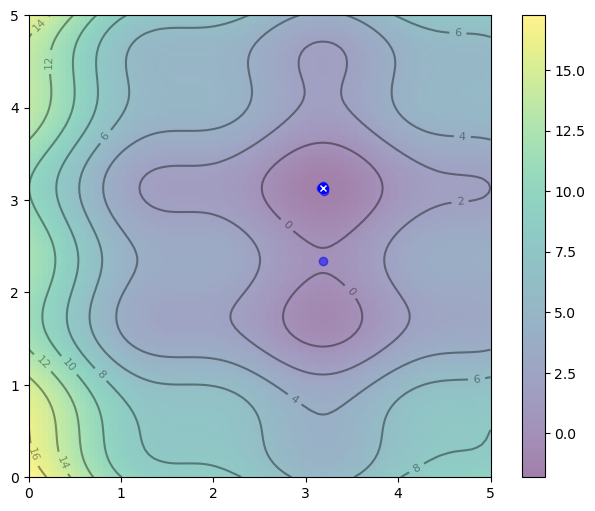

DPSO found best solution at f([3.18515536 3.12980723])=-1.8083520357510499


In [158]:
# Plotting and Animation
x, y = np.array(np.meshgrid(np.linspace(0, 5, 100), np.linspace(0, 5, 100)))
z = f(x, y)
x_min, y_min = x.ravel()[z.argmin()], y.ravel()[z.argmin()]

fig, ax = plt.subplots(figsize=(8, 6))
img = ax.imshow(z, extent=[0, 5, 0, 5], origin='lower', cmap='viridis', alpha=0.5)
fig.colorbar(img, ax=ax)
ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
p_plot = ax.scatter(positions[0][0], positions[0][1], marker='o', color='blue', alpha=0.5)
nbest_plot = plt.scatter([nbest[0]], [nbest[1]], marker='*', s=100, color='black', alpha=0.4)

def animate(i):
    ax.clear()
    ax.imshow(z, extent=[0, 5, 0, 5], origin='lower', cmap='viridis', alpha=0.5)
    ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
    contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
    ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
    for pos in positions:
        p_plot = ax.scatter(pos[i][0], pos[i][1], marker='o', color='blue', alpha=0.5)
    nbest_plot.set_offsets(nbest.reshape(1, -1))
    return ax, p_plot, nbest_plot

anim = FuncAnimation(fig, animate, frames=len(positions[0]), interval=500, blit=False, repeat=True)
anim.save("PSO-levy.gif", dpi=120, writer="imagemagick")
plt.show()

print("DPSO found best solution at f({})={}".format(nbest, nbest_obj))
